## Libraries Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

import cv2
import zipfile
import os

import warnings
warnings.filterwarnings('ignore')

## Dataset load

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [8]:
local_file = '/content/drive/MyDrive/Dataset/Sampah Plastik New.zip'
zip_ref = zipfile.ZipFile(local_file, 'r')
zip_ref.extractall('data/')
zip_ref.close()

### Use ImageDataGenerator to get class from folder name

In [9]:
BASE_DIR = '/content/data/Sampah Plastik New'

training_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest',
    validation_split=0.2
)

train_generator = training_datagen.flow_from_directory(BASE_DIR,
                                                       target_size=(200, 200),
                                                       batch_size=20,
                                                       class_mode='categorical',
                                                       subset='training')

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

validation_generator = validation_datagen.flow_from_directory(BASE_DIR,
                                                              target_size=(200, 200),
                                                              batch_size=20,
                                                              class_mode='categorical',
                                                              subset='validation')

Found 1109 images belonging to 7 classes.
Found 273 images belonging to 7 classes.


In [10]:
x,y = next(train_generator)
x.shape

(20, 200, 200, 3)

## Plot the images and its labels

Dataset label classes: ['HDPE', 'LDPE', 'Other', 'PET', 'PP', 'PS', 'PVC']


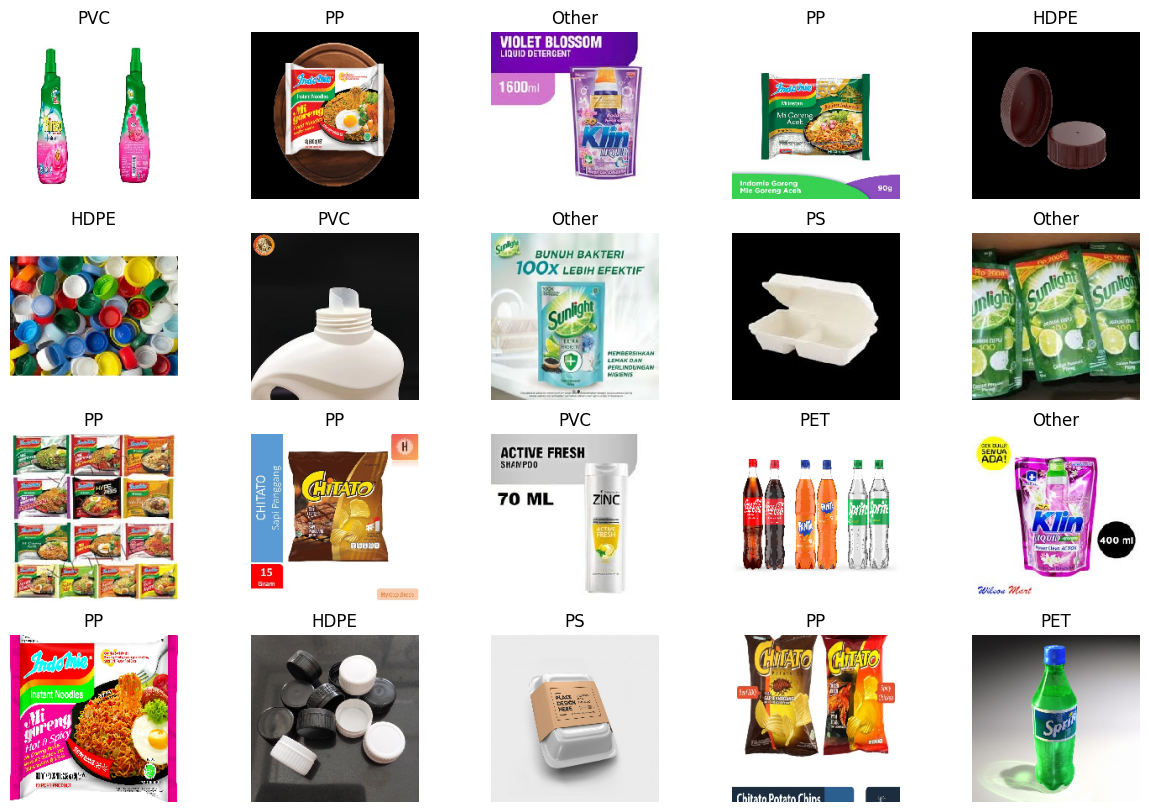

In [11]:
a = train_generator.class_indices
class_names = list(a.keys())
print(f'Dataset label classes: {class_names}')

def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(20):
        plt.subplot(4, 5, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

plot_images(x,y)

## Build Model

We will use EfficientNetV2 Small model for transfer learning to get faster and efficient training performance

In [ ]:
base_model = tf.keras.applications.EfficientNetV2S(include_top=False,
                                                   weights='imagenet',
                                                   input_shape=(200,200,3))

base_model.trainable=False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.BatchNormalization(renorm=True),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
    ])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Function  (None, 7, 7, 1280)        20331360  
 al)                                                             
                                                                 
 batch_normalization_2 (Bat  (None, 7, 7, 1280)        8960      
 chNormalization)                                                
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 512)               655872    
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                      

### Compile the model

In [ ]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [ ]:
batch_size=32
train_steps = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# fit model
history = model.fit(train_generator,
                    steps_per_epoch=train_steps,
                    validation_data=validation_generator,
                    validation_steps=validation_steps,
                    epochs=100)

Epoch 1/100
55/55 [==============================] - 8s 144ms/step - loss: 0.9140 - accuracy: 0.6694 - val_loss: 1.5891 - val_accuracy: 0.4462
Epoch 2/100
55/55 [==============================] - 10s 182ms/step - loss: 0.9612 - accuracy: 0.6437 - val_loss: 1.6501 - val_accuracy: 0.4192
Epoch 3/100
55/55 [==============================] - 9s 165ms/step - loss: 0.9047 - accuracy: 0.6593 - val_loss: 1.6613 - val_accuracy: 0.4385
Epoch 4/100
55/55 [==============================] - 8s 149ms/step - loss: 0.9356 - accuracy: 0.6520 - val_loss: 1.7063 - val_accuracy: 0.3885
Epoch 5/100
55/55 [==============================] - 9s 173ms/step - loss: 0.8954 - accuracy: 0.6804 - val_loss: 1.6352 - val_accuracy: 0.4077
Epoch 6/100
55/55 [==============================] - 9s 154ms/step - loss: 0.8575 - accuracy: 0.6814 - val_loss: 1.8192 - val_accuracy: 0.4000
Epoch 7/100
55/55 [==============================] - 10s 167ms/step - loss: 0.8554 - accuracy: 0.7052 - val_loss: 1.8624 - val_accuracy: 0.40

### Visualize the model performance

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.8521579504013062\nValidation Accuracy: 0.42307692766189575')

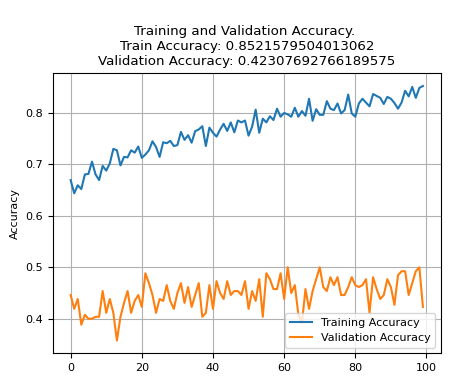

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(5, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 8
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

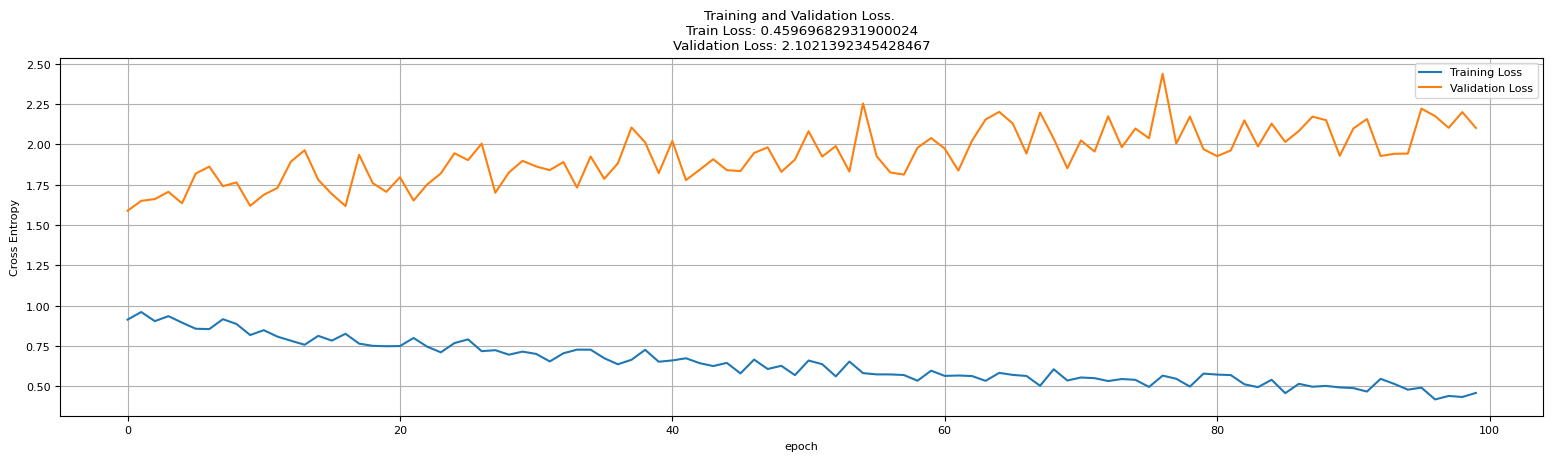

In [ ]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

## Make prediction from an image

1/1 [==============================] - 0s 106ms/step
Predicted class: Other
Class probabilities: [[2.29593006e-05 6.37123361e-03 8.60086262e-01 1.13256648e-03
  1.19665988e-01 4.91160463e-05 1.26718655e-02]]


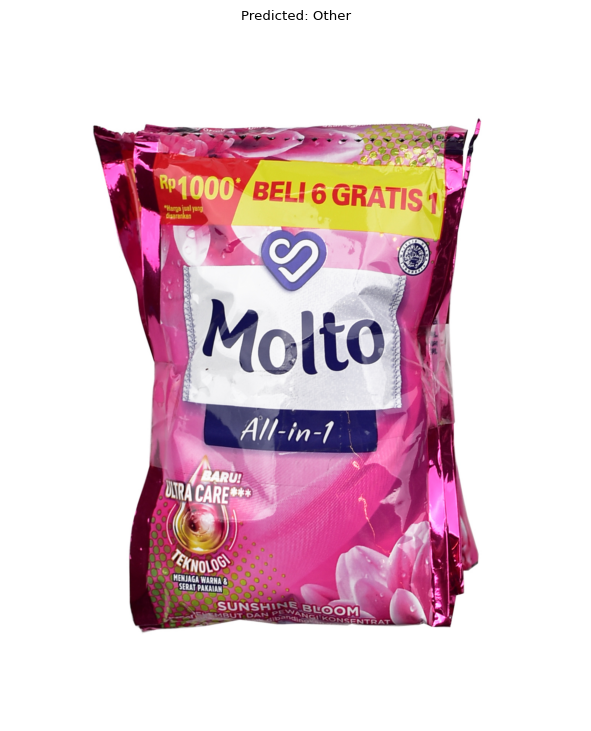

In [ ]:
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path, target_size=(200, 200)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

def predict_image_class(model, img_array, class_names):
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_class_name = class_names[predicted_class[0]]
    return predicted_class_name, predictions

def display_image_with_prediction(image_path, predicted_class_name):
    img = image.load_img(image_path)
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class_name}')
    plt.axis('off')
    plt.show()

image_path = '/content/molto.jpg'
img_array = load_and_preprocess_image(image_path)
predicted_class_name, predictions = predict_image_class(model, img_array, class_names)

print(f'Predicted class: {predicted_class_name}')
print(f'Class probabilities: {predictions}')

display_image_with_prediction(image_path, predicted_class_name)

## Save the model as H5 and TFLite

In [ ]:
model.save('ecovisionv2.h5')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('ecovisionv2.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
from google.colab import files
files.download('ecovisionv2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import filesv
files.download('ecovisionv2.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Load the saved model

In [12]:
model_dir = '/content/drive/MyDrive/model/Classification Model/ecovisionv2.h5'

model = tf.keras.models.load_model(model_dir)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Function  (None, 7, 7, 1280)        20331360  
 al)                                                             
                                                                 
 batch_normalization_2 (Bat  (None, 7, 7, 1280)        8960      
 chNormalization)                                                
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 512)               655872    
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                      

## Make prediction from the saved model

1/1 [==============================] - 0s 34ms/step
Predicted class: PS
Class probabilities: [[0.21868871 0.11390832 0.02302877 0.05710728 0.03495691 0.37115905
  0.18115093]]


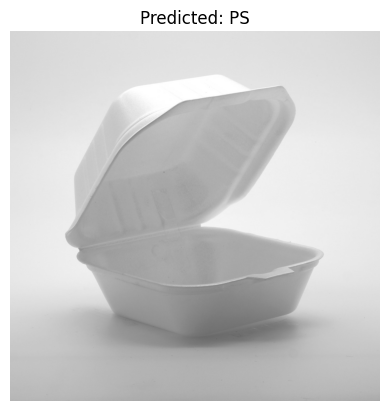

In [20]:
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path, target_size=(200, 200)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

def predict_image_class(model, img_array, class_names):
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_class_name = class_names[predicted_class[0]]
    return predicted_class_name, predictions

def display_image_with_prediction(image_path, predicted_class_name):
    img = image.load_img(image_path)
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class_name}')
    plt.axis('off')
    plt.show()

class_names = ['HDPE', 'LDPE', 'Other', 'PET', 'PP', 'PS', 'PVC']

image_path = 'styrofoam.jpg'
img_array = load_and_preprocess_image(image_path)
predicted_class_name, predictions = predict_image_class(model, img_array, class_names)

print(f'Predicted class: {predicted_class_name}')
print(f'Class probabilities: {predictions}')

display_image_with_prediction(image_path, predicted_class_name)